Rain Prediction in INDIA:

---


Indian Weather, Astronomy and Location Data collected using Weather API

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score
import pickle


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the data
weather_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Rain Predict/forecast_data.csv")
location_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Rain Predict/location_data.csv")

In [4]:
weather_data.head()

,time_epoch,time,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,state,city
0,1634236200,2021-10-15 00:00,23.2,73.8,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",4.3,6.8,41,NE,...,0,0,0,0,10.0,6.0,8.9,14.4,Andhra Pradesh,Amaravati
1,1634239800,2021-10-15 01:00,23.0,73.3,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",4.1,6.6,34,NE,...,0,0,0,0,10.0,6.0,8.6,13.9,Andhra Pradesh,Amaravati
2,1634243400,2021-10-15 02:00,22.7,72.9,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",4.0,6.4,28,NNE,...,0,0,0,0,10.0,6.0,8.4,13.4,Andhra Pradesh,Amaravati
3,1634247000,2021-10-15 03:00,22.5,72.5,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",3.8,6.1,22,NNE,...,0,0,0,0,10.0,6.0,8.1,13.0,Andhra Pradesh,Amaravati
4,1634250600,2021-10-15 04:00,22.3,72.1,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",3.7,6.0,23,NNE,...,0,0,0,0,10.0,6.0,7.9,12.7,Andhra Pradesh,Amaravati


In [5]:
location_data.head()

,name,region,country,lat,lon,tz_id,localtime_epoch,localtime
0,Amaravati,Maharashtra,India,20.93,77.75,Asia/Kolkata,1634903533,2021-10-22 17:22
1,Visakhapatnam,Andhra Pradesh,India,17.70,83.30,Asia/Kolkata,1634903543,2021-10-22 17:22
2,Vijayawada,Andhra Pradesh,India,16.52,80.62,Asia/Kolkata,1634903553,2021-10-22 17:22
3,Guntur,Andhra Pradesh,India,16.30,80.45,Asia/Kolkata,1634903564,2021-10-22 17:22
4,Nellore,Andhra Pradesh,India,14.43,79.97,Asia/Kolkata,1634903574,2021-10-22 17:22


In [6]:
# Plotting the cities for which we have the data for
INDIA_COORDINATES = [20.5937, 78.9629]

my_map = folium.Map(INDIA_COORDINATES) # Creates a map
def plot_map(df):
  # The function will add markers at the coordinates present in our dataframe
  folium.Marker(location=[df.lat, df.lon]).add_to(my_map)

# Apply the function to the dataframe
location_data.apply(plot_map, axis=1)
my_map.fit_bounds([[30.3753, 69.3451], [7.8731, 80.7718]])
my_map

In [7]:
# Extract the condition text from the json string
weather_data['condition'] = weather_data['condition'].apply(lambda x : eval(x)['text'])

In [8]:
weather_data.head()

,time_epoch,time,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,state,city
0,1634236200,2021-10-15 00:00,23.2,73.8,0,Clear,4.3,6.8,41,NE,...,0,0,0,0,10.0,6.0,8.9,14.4,Andhra Pradesh,Amaravati
1,1634239800,2021-10-15 01:00,23.0,73.3,0,Clear,4.1,6.6,34,NE,...,0,0,0,0,10.0,6.0,8.6,13.9,Andhra Pradesh,Amaravati
2,1634243400,2021-10-15 02:00,22.7,72.9,0,Clear,4.0,6.4,28,NNE,...,0,0,0,0,10.0,6.0,8.4,13.4,Andhra Pradesh,Amaravati
3,1634247000,2021-10-15 03:00,22.5,72.5,0,Clear,3.8,6.1,22,NNE,...,0,0,0,0,10.0,6.0,8.1,13.0,Andhra Pradesh,Amaravati
4,1634250600,2021-10-15 04:00,22.3,72.1,0,Clear,3.7,6.0,23,NNE,...,0,0,0,0,10.0,6.0,7.9,12.7,Andhra Pradesh,Amaravati


In [9]:
weather_data['state'].unique()

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu',
       'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [10]:
weather_data['city'].unique()

array(['Amaravati', 'Visakhapatnam', 'Vijayawada', 'Guntur', 'Nellore',
       'Tirupati', 'Itanagar', 'Tawang', 'Pasighat', 'Ziro', 'Bomdila',
       'Dispur', 'Guwahati', 'Tezpur', 'Dibrugarh', 'Silchar',
       'North Lakhimpur', 'Patna', 'Gaya', 'Darbhanga', 'Bhagalpur',
       'Raipur', 'Bilaspur', 'Korba', 'Raigarh', 'Panaji',
       'Vasco-da-Gama', 'Ponda', 'Margao', 'Mapusa', 'Goa Velha',
       'Gandhinagar', 'Ahmedabad', 'Surat', 'Rajkot', 'Junagadh',
       'Vadodara', 'Chandigarh', 'Faridabad', 'Gurgaon', 'Sonipat',
       'Panipat', 'Ambala', 'Shimla', 'Mandi', 'Solan', 'Chamba',
       'Ranchi', 'Bokaro Steel City', 'Jamshedpur', 'Deoghar',
       'Hazaribagh', 'Dhanbad', 'Bengaluru', 'Mysore', 'Davangere',
       'Mangalore', 'Hubli-Dharwad', 'Belgaum', 'Thiruvananthapuram',
       'Kochi', 'Kozhikode', 'Thrissur', 'Malappuram', 'Bhopal', 'Indore',
       'Gwalior', 'Jabalpur', 'Ujjain', 'Sagar', 'Mumbai', 'Pune',
       'Nagpur', 'Aurangabad', 'Solapur', 'Imphal', 'Bis

In [11]:
l=weather_data['city'].unique()
len(l) #unique cities

151

In [12]:
weather_data['condition'].unique()

array(['Clear', 'Sunny', 'Patchy rain possible', 'Light rain shower',
       'Partly cloudy', 'Cloudy', 'Moderate rain',
       'Moderate or heavy rain shower', 'Patchy light rain',
       'Patchy light drizzle', 'Mist', 'Overcast',
       'Thundery outbreaks possible',
       'Moderate or heavy snow with thunder', 'Light snow showers',
       'Patchy light snow with thunder', 'Light drizzle', 'Light rain',
       'Fog', 'Moderate rain at times', 'Heavy rain',
       'Patchy light rain with thunder', 'Torrential rain shower'],
      dtype=object)

In [13]:
weather_data.isnull().sum()

time_epoch        0
time              0
temp_c            0
temp_f            0
is_day            0
condition         0
wind_mph          0
wind_kph          0
wind_degree       0
wind_dir          0
pressure_mb       0
pressure_in       0
precip_mm         0
precip_in         0
humidity          0
cloud             0
feelslike_c       0
feelslike_f       0
windchill_c       0
windchill_f       0
heatindex_c       0
heatindex_f       0
dewpoint_c        0
dewpoint_f        0
will_it_rain      0
chance_of_rain    0
will_it_snow      0
chance_of_snow    0
vis_km            0
vis_miles         0
gust_mph          0
gust_kph          0
state             0
city              0
dtype: int64

In [14]:
weather_data.shape

(29568, 34)

In [15]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_epoch      29568 non-null  int64  
 1   time            29568 non-null  object 
 2   temp_c          29568 non-null  float64
 3   temp_f          29568 non-null  float64
 4   is_day          29568 non-null  int64  
 5   condition       29568 non-null  object 
 6   wind_mph        29568 non-null  float64
 7   wind_kph        29568 non-null  float64
 8   wind_degree     29568 non-null  int64  
 9   wind_dir        29568 non-null  object 
 10  pressure_mb     29568 non-null  float64
 11  pressure_in     29568 non-null  float64
 12  precip_mm       29568 non-null  float64
 13  precip_in       29568 non-null  float64
 14  humidity        29568 non-null  int64  
 15  cloud           29568 non-null  int64  
 16  feelslike_c     29568 non-null  float64
 17  feelslike_f     29568 non-null 

In [16]:
weather_data.describe()

,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,...,dewpoint_c,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph
count,2.956800e+04,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,...,29568.000000,29568.000000,29568.000000,29568.000000,29568.0,29568.0,29568.000000,29568.000000,29568.000000,29568.000000
mean,1.634580e+09,25.152307,77.273793,0.477070,5.077486,8.169619,177.818452,1008.341112,29.775472,0.101552,...,18.650761,65.571567,0.089928,12.155202,0.0,0.0,9.263460,5.488433,7.947697,12.791274
std,1.995536e+05,4.797702,8.635461,0.499482,2.847123,4.582337,103.545331,3.438631,0.101294,0.406883,...,5.715956,10.288746,0.286084,24.999675,0.0,0.0,1.986747,1.281815,4.141102,6.665310
min,1.634227e+09,1.500000,34.700000,0.000000,0.000000,0.000000,0.000000,999.000000,29.490000,0.000000,...,-8.200000,17.200000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.634408e+09,22.500000,72.600000,0.000000,3.100000,4.900000,83.000000,1006.000000,29.690000,0.000000,...,16.000000,60.800000,0.000000,0.000000,0.0,0.0,10.000000,6.000000,4.900000,7.900000
50%,1.634580e+09,25.100000,77.200000,0.000000,4.500000,7.200000,174.000000,1008.000000,29.780000,0.000000,...,20.400000,68.700000,0.000000,0.000000,0.0,0.0,10.000000,6.000000,7.300000,11.800000
75%,1.634753e+09,28.100000,82.600000,1.000000,6.500000,10.400000,273.000000,1011.000000,29.850000,0.040000,...,22.900000,73.300000,0.000000,3.000000,0.0,0.0,10.000000,6.000000,10.400000,16.700000
max,1.634958e+09,39.300000,102.700000,1.000000,22.400000,36.000000,359.000000,1021.000000,30.160000,20.930000,...,30.200000,86.400000,1.000000,94.000000,0.0,0.0,10.000000,6.000000,32.700000,52.600000


In [17]:
# Many columns are same just with differnt units, for ex wind_mph and wind_kph. So, it's better to remove the redundancy
redundant_columns = ['temp_f', 'wind_kph', 'pressure_in', 'precip_in', 'feelslike_f', 'windchill_f', 'heatindex_f', 'dewpoint_f', 'vis_miles', 'chance_of_rain', 'chance_of_snow','gust_kph']

# Drop the redundant information
weather_data.drop(redundant_columns, axis=1, inplace=True)

# EDA

In [18]:
weather_data.head()

,time_epoch,time,temp_c,is_day,condition,wind_mph,wind_degree,wind_dir,pressure_mb,precip_mm,...,feelslike_c,windchill_c,heatindex_c,dewpoint_c,will_it_rain,will_it_snow,vis_km,gust_mph,state,city
0,1634236200,2021-10-15 00:00,23.2,0,Clear,4.3,41,NE,1006.0,0.0,...,25.1,23.2,25.1,16.7,0,0,10.0,8.9,Andhra Pradesh,Amaravati
1,1634239800,2021-10-15 01:00,23.0,0,Clear,4.1,34,NE,1005.0,0.0,...,25.0,23.0,25.0,16.5,0,0,10.0,8.6,Andhra Pradesh,Amaravati
2,1634243400,2021-10-15 02:00,22.7,0,Clear,4.0,28,NNE,1005.0,0.0,...,24.9,22.7,24.9,16.4,0,0,10.0,8.4,Andhra Pradesh,Amaravati
3,1634247000,2021-10-15 03:00,22.5,0,Clear,3.8,22,NNE,1005.0,0.0,...,24.8,22.5,24.8,16.2,0,0,10.0,8.1,Andhra Pradesh,Amaravati
4,1634250600,2021-10-15 04:00,22.3,0,Clear,3.7,23,NNE,1005.0,0.0,...,24.7,22.3,24.7,16.1,0,0,10.0,7.9,Andhra Pradesh,Amaravati


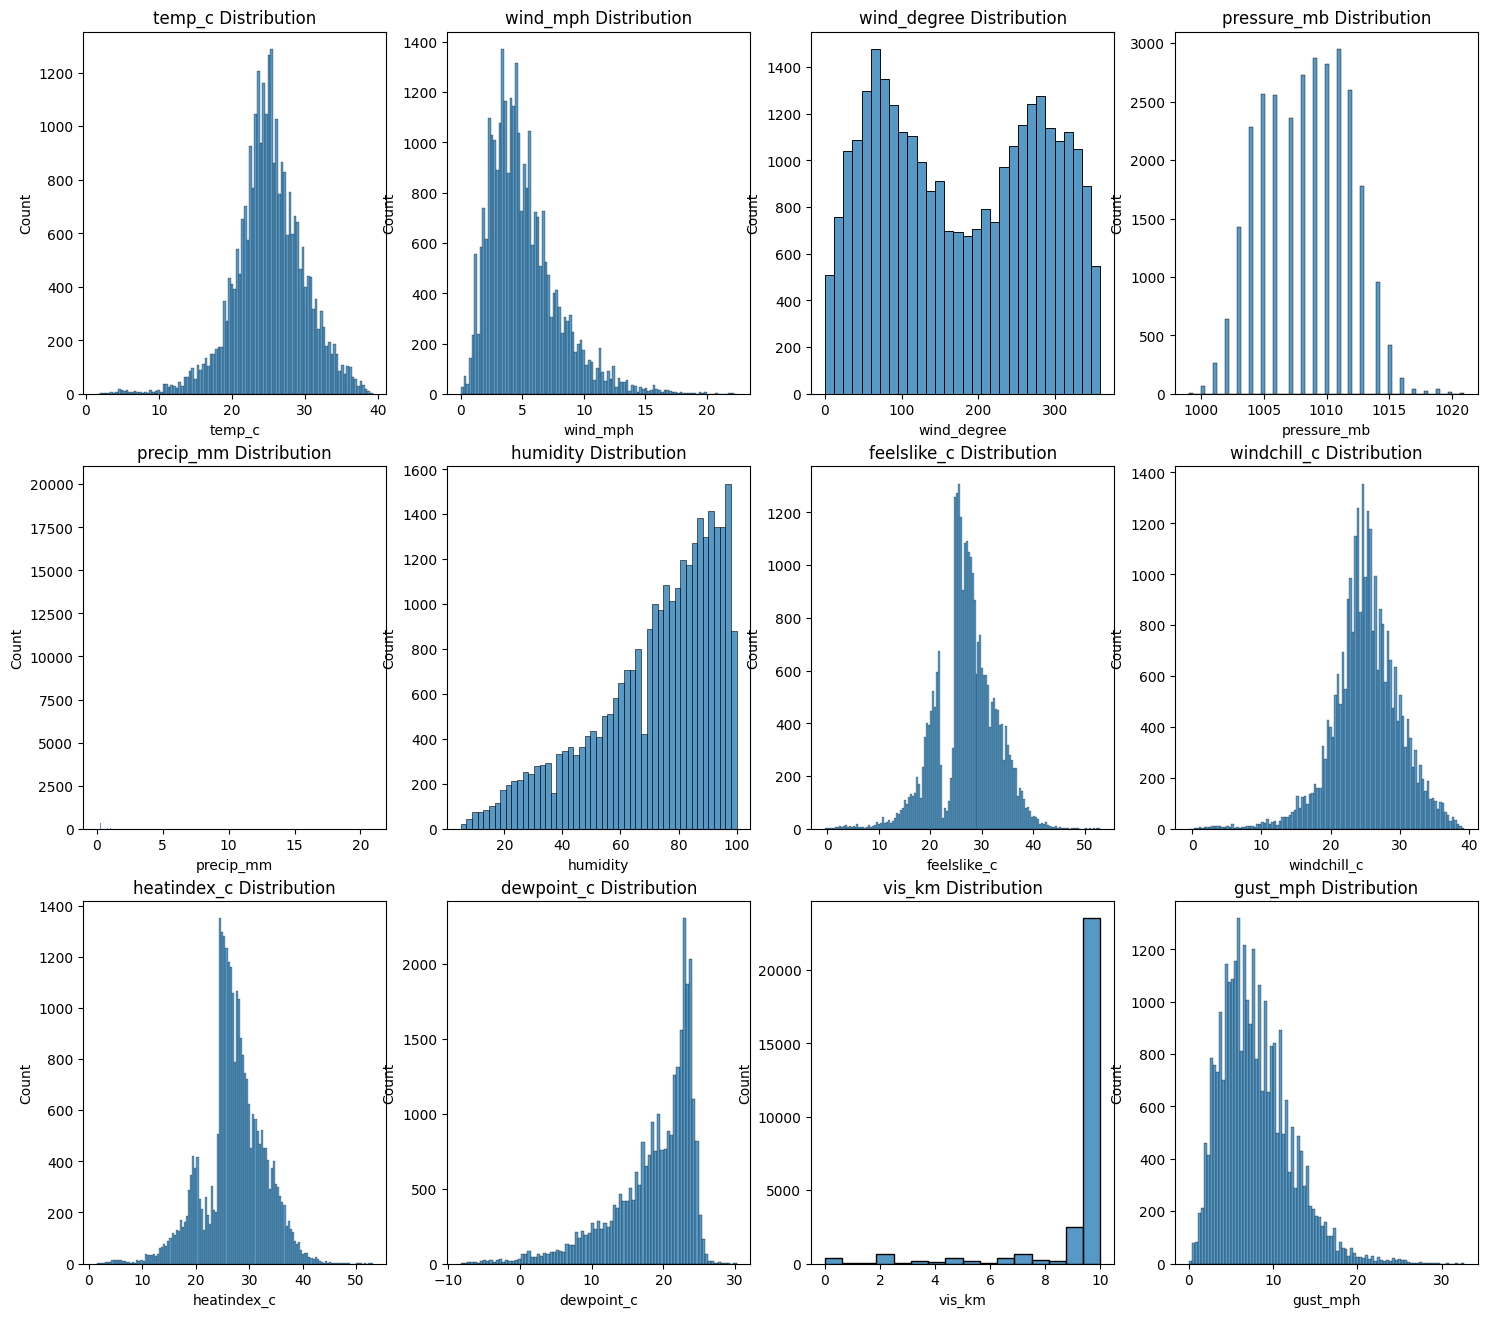

In [19]:
# Visualise various continuous distributions
continuous_distributions = ['temp_c', 'wind_mph', 
                            'wind_degree', 'pressure_mb', 
                            'precip_mm', 'humidity', 
                            'feelslike_c', 'windchill_c', 
                            'heatindex_c', 'dewpoint_c', 
                            'vis_km', 'gust_mph']

plt.figure(figsize=(18, 16))
for i, dist_col in enumerate(continuous_distributions):

  # Create subplots
  plt.subplot(3, 4, i+1)
  sns.histplot(weather_data[dist_col])
  plt.title(dist_col + " Distribution")

**precip_mm columns graph looks empty, lets plot again after altering xticks**

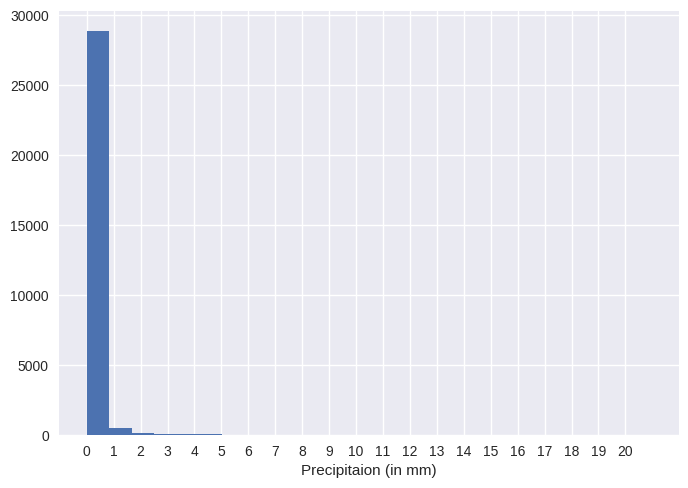

In [20]:
plt.style.use('seaborn')
weather_data['precip_mm'].hist(bins=25)
plt.xlabel("Precipitaion (in mm)")
plt.xticks(np.arange(0,21,1))
plt.show()

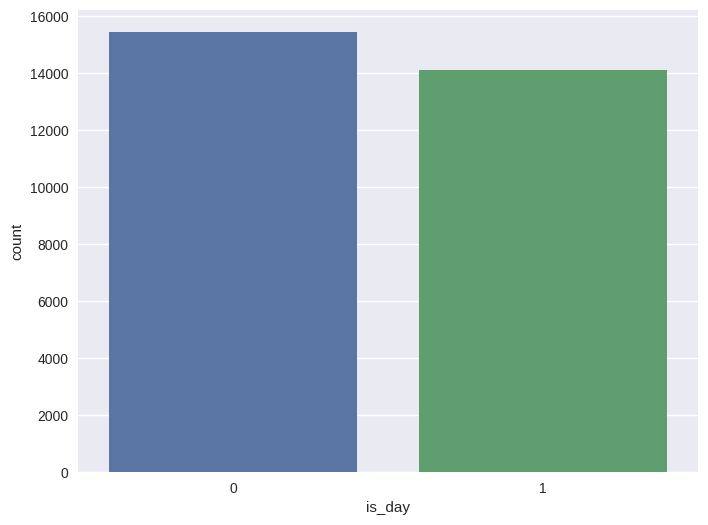

In [21]:
# Plotting categorical discrete variables

# 1. Plotting days and nights count
plt.figure(figsize=(8,6))
sns.countplot(data=weather_data, x='is_day')
plt.show()


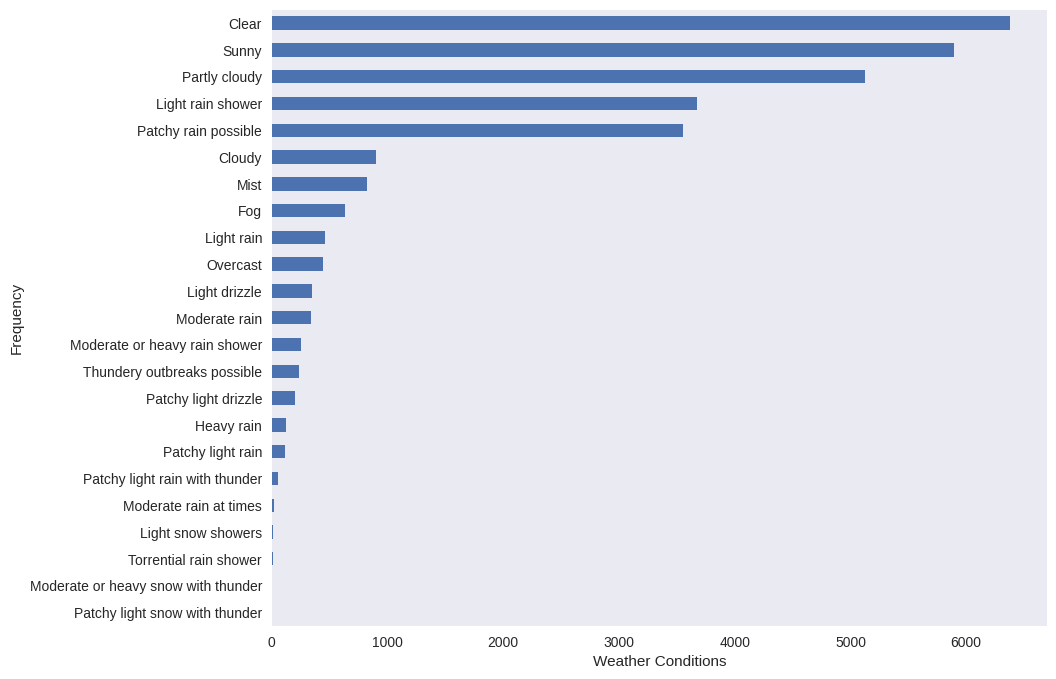

In [22]:
weather_data['condition'].value_counts().sort_values().plot(kind='barh', figsize=(10,8))
plt.xlabel("Weather Conditions")
plt.ylabel("Frequency")
plt.grid()
plt.show()

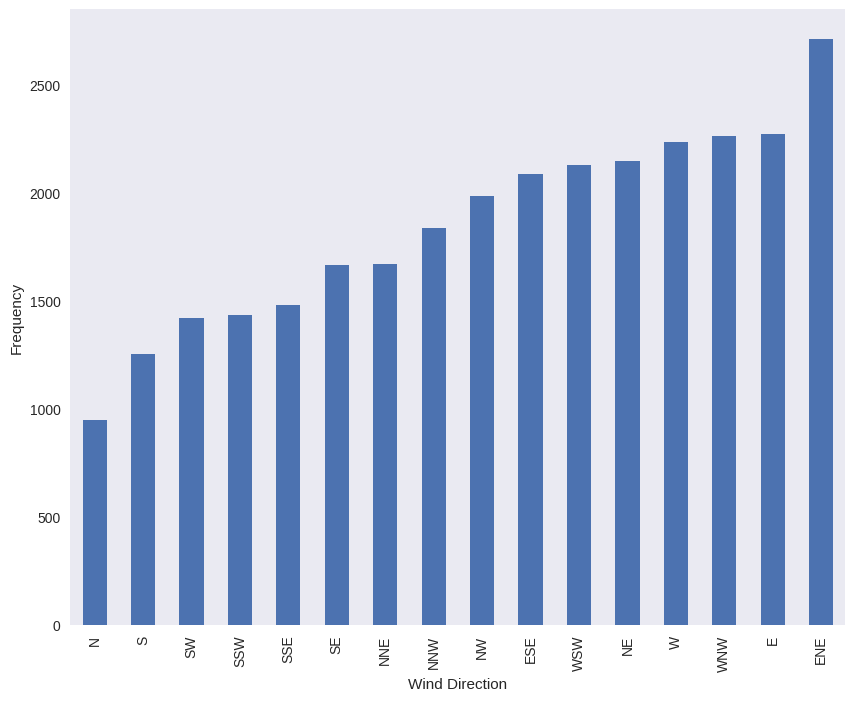

In [23]:
weather_data['wind_dir'].value_counts().sort_values().plot(kind='bar', figsize=(10,8))
plt.xlabel("Wind Direction")
plt.ylabel("Frequency")
plt.grid()
plt.show()

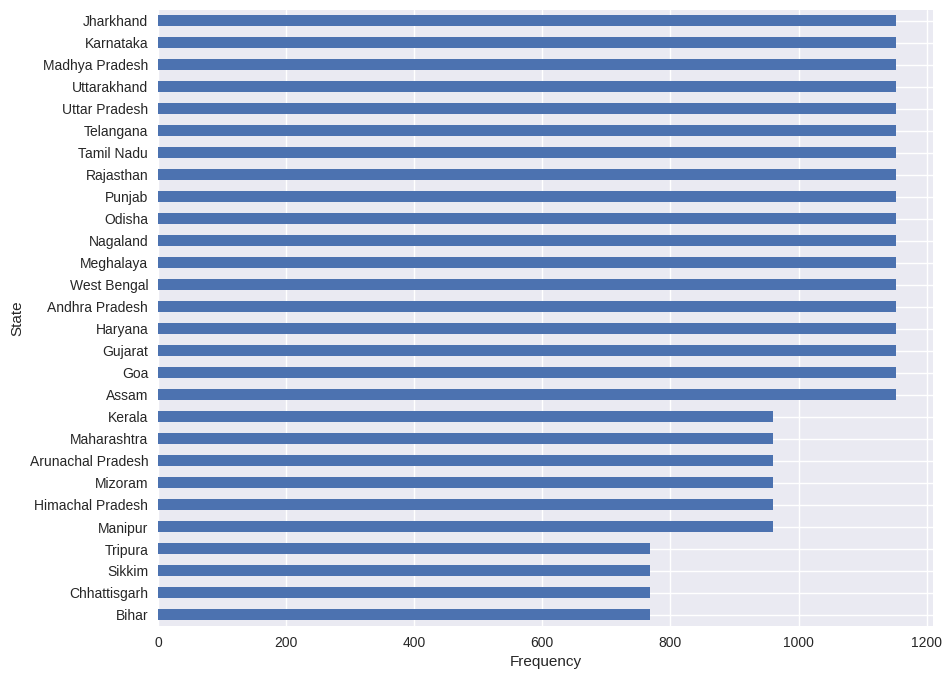

In [24]:
# Plot state distribution
weather_data['state'].value_counts().sort_values().plot(kind='barh', figsize=(10,8))
plt.xlabel("Frequency")
plt.ylabel("State")
plt.show()

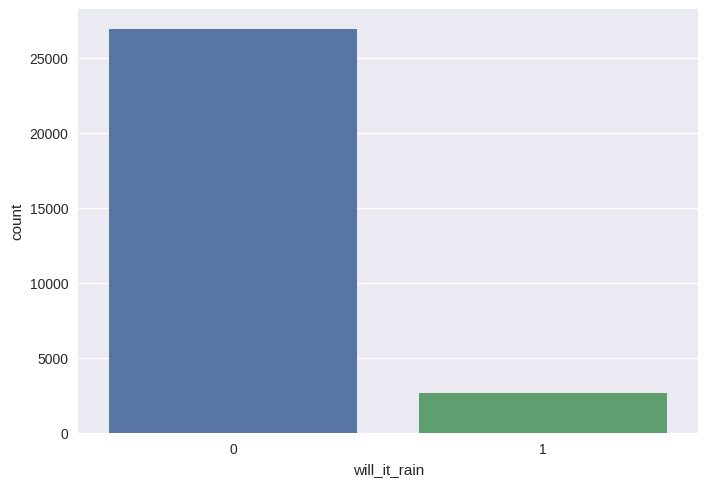

In [25]:
# Plot the count of rainy forecasts
sns.countplot(data=weather_data, x='will_it_rain')
plt.show()

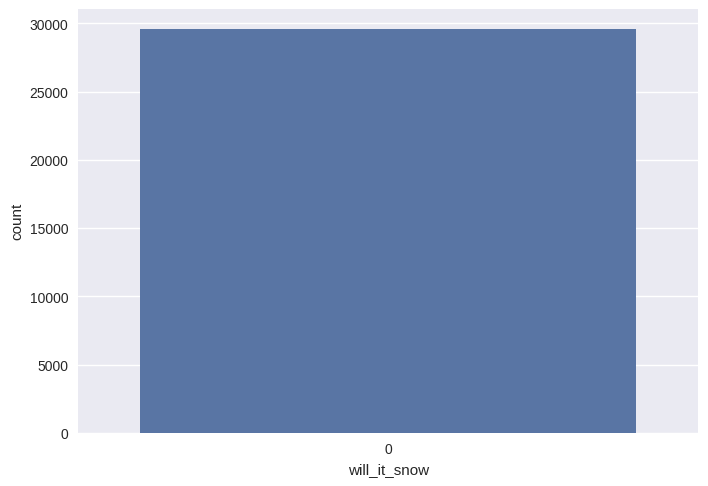

In [26]:
# Plot the count of snow forecasts
sns.countplot(data=weather_data, x='will_it_snow')
plt.show()

**No forecasts of snow in the past 7 days in the country**

In [27]:
# Drop the snow column as it has constant variance
weather_data.drop(['will_it_snow'], axis=1, inplace=True)

In [28]:
# Group the data by states
grouped_state_data = weather_data.groupby('state')

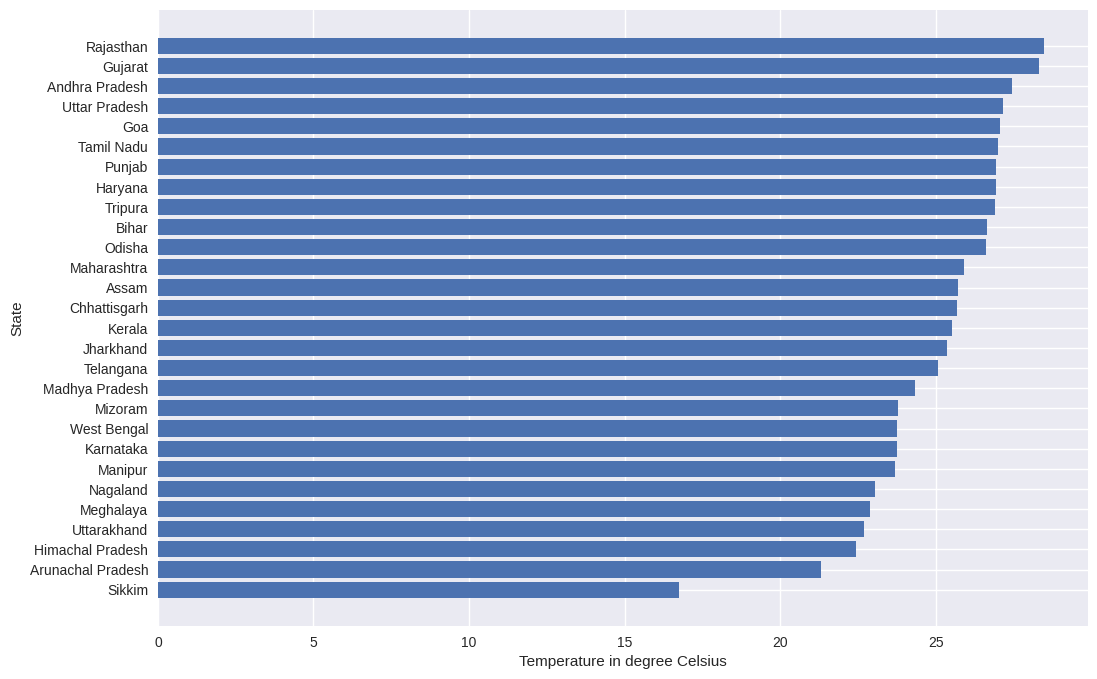

In [29]:
# State wise analysis
state_data = weather_data.groupby('state').mean().reset_index()

# Plotting each states mean temperature in degree celsius
plt.figure(figsize=(12,8))
plt.barh(y = state_data.sort_values(by='temp_c')['state'], width = state_data.sort_values(by='temp_c')['temp_c'])
plt.xlabel("Temperature in degree Celsius")
plt.ylabel("State")
plt.show()



1.   State of Rajasthan has the maximum average temperature from 15/10/21 - 22/10/21.
2.   State of Sikkim has the minimum average temperature from 15/10/21 - 22/10/21.



In [ ]:
# store the name of the states in a list and sort them alphabetically
states = [state for state in weather_data['state'].value_counts().index]
states.sort()
print(states)

['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']


In [ ]:
continuous_distributions.append('will_it_rain')
continuous_distributions.append('cloud')

In [ ]:
columns_to_analyze_1 = continuous_distributions
columns_to_analyze_2 = ['condition', 'wind_dir']

In [ ]:
# Time Series Analysis
def statewise_data_analysis(columns_to_analyze_1, columns_to_analyze_2):

  label_map = ['Day {}'.format(i) for i in range(1, 16)]
  ticks = [i for i in range(1,16)]

  # Plotting average daily distributions from 15/10/2021-22/10/2021

  for i in range(len(states)):

    # Perform analysis for each state
    state = states[i]
    state_i_data = grouped_state_data.get_group(state)
    state_i_data['time'] = pd.to_datetime(state_i_data['time'])

    print("=========================================================================={}'s ANALYSIS=================================================================================".format(state.upper()))
    print()

    # Group the data by time
    time_data = state_i_data.groupby('time').mean()

    # Plot the daily average of all the continuous distributions and numerical variable
    columns_to_analyze_1 = continuous_distributions
    plt.figure(figsize=(25, 25))
    for i, col in enumerate(columns_to_analyze_1):
      plt.subplot(5, 5, i + 1)
      plt.plot(time_data[col])
      #plt.xticks(rotation=-45)
      plt.xlabel("Date")
      plt.ylabel(col)
    plt.show()

    # Plotting categorical variable across states
    plt.figure(figsize=(25, 12))
    for j in range(len(columns_to_analyze_2)):
      plt.subplot(1, 2, j+1)
      curr_column = columns_to_analyze_2[j]
      data_to_plot = state_i_data[curr_column].value_counts().sort_values()
      plt.barh(y=data_to_plot.index, width=data_to_plot.values)
      plt.xlabel("Frequency")
      plt.ylabel(curr_column)
    plt.show()
    
    print("====================================================================================================================================================================================".format(state.upper()))
    print()

# call the function
statewise_data_analysis(columns_to_analyze_1, columns_to_analyze_2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Analysizng features and their dependence on predicting whether it will rain or not
weather_data.groupby('will_it_rain').mean()

,time_epoch,temp_c,is_day,wind_mph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,vis_km,gust_mph
will_it_rain,,,,,,,,,,,,,,,
0,1.634580e+09,25.213891,0.474042,5.063811,178.711398,1008.418633,0.085797,70.224349,39.323126,27.015381,25.199606,27.162674,18.286387,9.242424,7.911320
1,1.634582e+09,24.529071,0.507710,5.215871,168.781873,1007.556600,0.260993,88.287702,78.172621,27.262279,24.525235,27.362956,22.338210,9.476344,8.315833


**From the above table, 'cloud' seems to be the feature which is makes a significant impact on predicting weather it will rain or not. (Which is quite logical).**

In [ ]:
columns_to_analyze_3 = list(weather_data.groupby('will_it_rain').mean().columns)
columns_to_analyze_3.remove('time_epoch')

In [ ]:
# Analysizng features and their dependence on predicting whether it will rain or not for each state
def statewise_rain_factor_analysis(columns_to_analyze_3):

  # Plotting boxplots for the feature 'will_it_rain' against the average of all other continuous features for each state

  for i in range(len(states)):

    # Perform analysis for each state
    state = states[i]
    state_i_data = grouped_state_data.get_group(state)

    print("=========================================================================={}'s ANALYSIS=================================================================================".format(state.upper()))
    print()

    plt.figure(figsize=(25, 25))
    for i, col in enumerate(columns_to_analyze_3):
      plt.subplot(7, 2, i + 1)
      sns.boxplot(data=state_i_data, x='will_it_rain', y=col)
      #plt.xticks(rotation=-45)
      plt.xlabel("Will it Rain 0 : No ; 1 : Yes")
      plt.ylabel(col)
    plt.show()
    
    print("====================================================================================================================================================================================".format(state.upper()))
    print()

# Call the above function
statewise_rain_factor_analysis(columns_to_analyze_3)

Output hidden; open in https://colab.research.google.com to view.

**Statewise analysis of factors shows a more granular approach on finding relation between features and the chances of raining.**

In [ ]:
continuous_distributions

['temp_c',
 'wind_mph',
 'wind_degree',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'feelslike_c',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'gust_mph',
 'will_it_rain',
 'cloud']

In [ ]:
continuous_distributions.remove('will_it_rain')

In [ ]:
continuous_distributions.remove('cloud')

In [ ]:
# Plotting scatter plots

'''Plotting each continuous distribution against every other continuous distribution'''
weather_data[continuous_distributions].head()
for i in range(len(continuous_distributions)):

  if i != len(continuous_distributions)-1:
    curr_column = continuous_distributions[i]
    print("================================================= {} SCATTER PLOT ===================================================".format(curr_column))
    print()
    num_rows = len(continuous_distributions) - i
    for j in range(i+1, len(continuous_distributions)):
      next_column = continuous_distributions[j]
      plt.figure(figsize=(8,6))
      sns.scatterplot(data=weather_data, x=curr_column, y=next_column)
      plt.show()
    print("=======================================================================================================================")
    print()

Output hidden; open in https://colab.research.google.com to view.

**Multicollinearity can be observed**

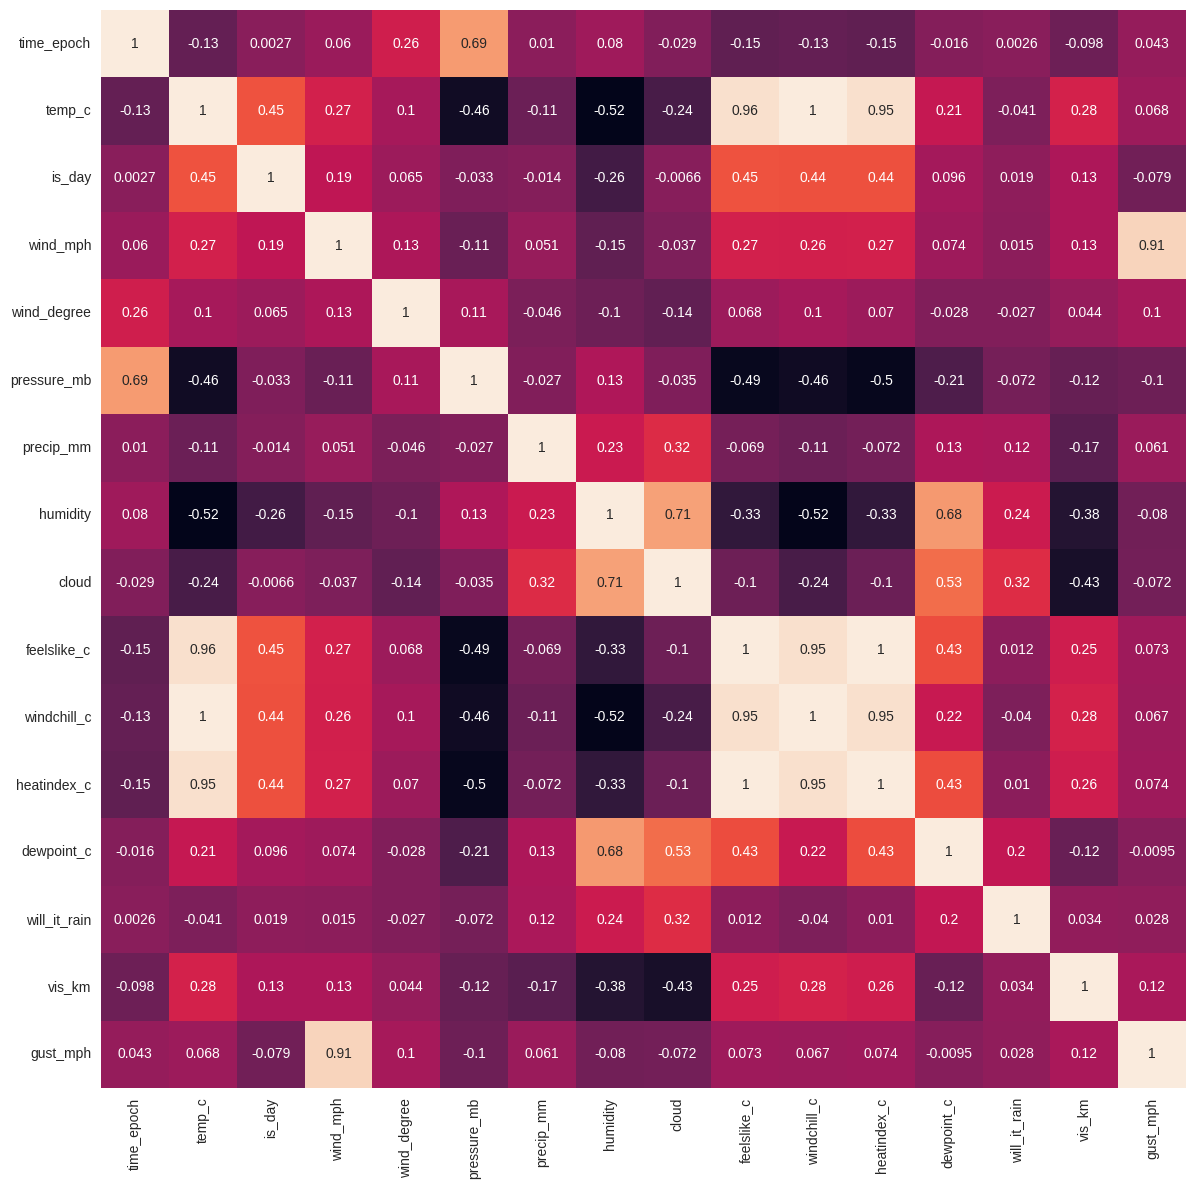

In [ ]:
# PLot the correlation heatmap
corr_matrix = weather_data.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cbar=False)
plt.show()

In [ ]:
weather_data.head()

,time_epoch,time,temp_c,is_day,condition,wind_mph,wind_degree,wind_dir,pressure_mb,precip_mm,...,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,will_it_rain,vis_km,gust_mph,state,city
0,1634236200,2021-10-15 00:00,23.2,0,Clear,4.3,41,NE,1006.0,0.0,...,5,25.1,23.2,25.1,16.7,0,10.0,8.9,Andhra Pradesh,Amaravati
1,1634239800,2021-10-15 01:00,23.0,0,Clear,4.1,34,NE,1005.0,0.0,...,6,25.0,23.0,25.0,16.5,0,10.0,8.6,Andhra Pradesh,Amaravati
2,1634243400,2021-10-15 02:00,22.7,0,Clear,4.0,28,NNE,1005.0,0.0,...,8,24.9,22.7,24.9,16.4,0,10.0,8.4,Andhra Pradesh,Amaravati
3,1634247000,2021-10-15 03:00,22.5,0,Clear,3.8,22,NNE,1005.0,0.0,...,10,24.8,22.5,24.8,16.2,0,10.0,8.1,Andhra Pradesh,Amaravati
4,1634250600,2021-10-15 04:00,22.3,0,Clear,3.7,23,NNE,1005.0,0.0,...,10,24.7,22.3,24.7,16.1,0,10.0,7.9,Andhra Pradesh,Amaravati


# Data Preprocessing

In [ ]:
# Encode the categorical text values
cols_to_encode = ['condition', 'wind_dir', 'state', 'city']
for col in cols_to_encode:
  le = LabelEncoder()
  weather_data[col] = le.fit_transform(weather_data[col])

In [ ]:
weather_data.head()

,time_epoch,time,temp_c,is_day,condition,wind_mph,wind_degree,wind_dir,pressure_mb,precip_mm,...,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,will_it_rain,vis_km,gust_mph,state,city
0,1634236200,2021-10-15 00:00,23.2,0,0,4.3,41,4,1006.0,0.0,...,5,25.1,23.2,25.1,16.7,0,10.0,8.9,0,7
1,1634239800,2021-10-15 01:00,23.0,0,0,4.1,34,4,1005.0,0.0,...,6,25.0,23.0,25.0,16.5,0,10.0,8.6,0,7
2,1634243400,2021-10-15 02:00,22.7,0,0,4.0,28,5,1005.0,0.0,...,8,24.9,22.7,24.9,16.4,0,10.0,8.4,0,7
3,1634247000,2021-10-15 03:00,22.5,0,0,3.8,22,5,1005.0,0.0,...,10,24.8,22.5,24.8,16.2,0,10.0,8.1,0,7
4,1634250600,2021-10-15 04:00,22.3,0,0,3.7,23,5,1005.0,0.0,...,10,24.7,22.3,24.7,16.1,0,10.0,7.9,0,7


In [ ]:
# drop the time column
weather_data.drop('time', axis=1, inplace=True)

In [ ]:
# Scale the data
X = weather_data.drop('will_it_rain', axis=1)
y = weather_data['will_it_rain']

X_columns = X.columns
ss = StandardScaler()
X_scaled_arr = ss.fit_transform(X)

# Create a new dataframe called X_scaled
X_scaled = pd.DataFrame(X_scaled_arr, columns=X_columns)

In [ ]:
X_scaled.head()

,time_epoch,temp_c,is_day,condition,wind_mph,wind_degree,wind_dir,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,vis_km,gust_mph,state,city
0,-1.723372,-0.406932,-0.955145,-1.350758,-0.273082,-1.321361,-0.682993,-0.680838,-0.249591,-0.225008,-1.098891,-0.330904,-0.400067,-0.364536,-0.341289,0.370733,0.229968,-1.690892,-1.544443
1,-1.705332,-0.448620,-0.955145,-1.350758,-0.343330,-1.388965,-0.682993,-0.971657,-0.249591,-0.225008,-1.069833,-0.347982,-0.441333,-0.382056,-0.376280,0.370733,0.157522,-1.690892,-1.544443
2,-1.687291,-0.511151,-0.955145,-1.350758,-0.378454,-1.446912,-0.478701,-0.971657,-0.249591,-0.225008,-1.011717,-0.365060,-0.503232,-0.399576,-0.393775,0.370733,0.109225,-1.690892,-1.544443
3,-1.669250,-0.552838,-0.955145,-1.350758,-0.448701,-1.504859,-0.478701,-0.971657,-0.249591,-0.225008,-0.953600,-0.382138,-0.544498,-0.417095,-0.428765,0.370733,0.036779,-1.690892,-1.544443
4,-1.651210,-0.594525,-0.955145,-1.350758,-0.483825,-1.495201,-0.478701,-0.971657,-0.249591,-0.178603,-0.953600,-0.399216,-0.585764,-0.434615,-0.446260,0.370733,-0.011518,-1.690892,-1.544443


# Feature Selection

In [ ]:
# Using recursive feature elimination to select optimal number of features

# Using an ensemble model like Random Forest to use as the model.

'''
Q. How to select a model for using RFE?
A. One approach, use a model that offers scoring of features, like feature_importances_ in Random Forest.
'''

rfe_model = RandomForestClassifier()
rfe = RFE(rfe_model, verbose=3)
X_rfe = rfe.fit_transform(X_scaled, y)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.


In [ ]:
# Extract the important features
feature_series = pd.Series(rfe.support_, index=X_columns)
important_features = list(feature_series[feature_series == True].index)

In [ ]:
print(important_features)

['time_epoch', 'condition', 'wind_degree', 'precip_mm', 'humidity', 'cloud', 'windchill_c', 'dewpoint_c', 'vis_km']


In [ ]:
# Prepare the final dataset
X_final = X_scaled[important_features]

# Classification

## Classification using ML techniques

In [ ]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [ ]:
'''
Chosing Metric:
The problem is on a given day, predict whether it will rain or not. 
Hence, in this case the priority should be reduce the number of False Negatives or reduce the type II error.

So, in this case Recall should be the ideal metric that should be optimised.

Recall = TP/(TP + FN) where, TP: True Positives ; FN: False Negatives
'''

# We are going to chose a model which gives maximum recall, in case of tie we are going to see which one gives maximum TPs.

# 1. Compute Recall Score
def compute_recall_score(model_dict, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

  model_name = list(model_dict.keys())[0]
  model_obj = list(model_dict.values())[0]

  # Make predictions

  # 1. Training predictions
  train_preds = model_obj.predict(X_train)

  # 2. Testing predictions
  test_preds = model_obj.predict(X_test)

  # Compute Recall Score

  # 1. Training Score
  train_recall = recall_score(y_train, train_preds)

  # 2. Testing score
  test_recall = recall_score(y_test, test_preds)

  # Display the result
  result_arr = np.array([train_recall, test_recall])
  result_df = pd.DataFrame(data = result_arr.reshape(1,2), columns = ['Train_Recall', 'Test_Recall'], index=[model_name])

  return result_df

# Plot the Confusion Matrix
def plot_confusion_matrix(model_dict, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

  model_name = list(model_dict.keys())[0]
  model_obj = list(model_dict.values())[0]

  # Make predictions

  # 1. Training predictions
  train_preds = model_obj.predict(X_train)

  # 2. Testing predictions
  test_preds = model_obj.predict(X_test)

  # Compute Recall Score

  # 1. Training Score
  train_recall = confusion_matrix(y_train, train_preds)

  # 2. Testing score
  test_recall = confusion_matrix(y_test, test_preds)

  # Plot the heatmap
  fig, ax = plt.subplots(1, 2, figsize=(15,8))

  # PLot the trainig matrix
  sns.heatmap(train_recall, annot=True, cbar=False, ax=ax[0], fmt='g')
  ax[0].set_xlabel("Predicted Values")
  ax[0].set_ylabel("Actual Values")
  ax[0].set_title("Training Set Results")

  # Plot the testing matrix
  sns.heatmap(test_recall, annot=True, cbar=False, ax=ax[1], fmt='g')
  ax[1].set_xlabel("Predicted Values")
  ax[1].set_ylabel("Actual Values")
  ax[1].set_title("Testing Set Results")

  fig.show()

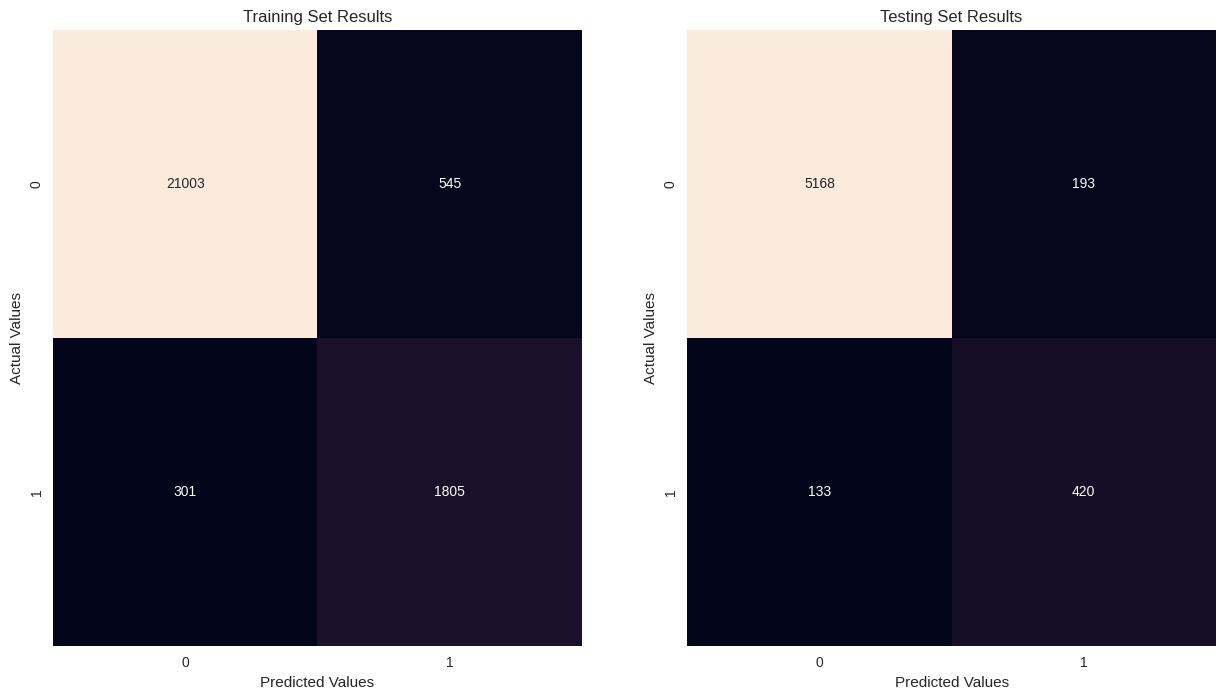

In [ ]:
# 1. Baseline Model -> KNN
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'KNN' : knn_clf}
knn_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
knn_results

,Train_Recall,Test_Recall
KNN,0.857075,0.759494


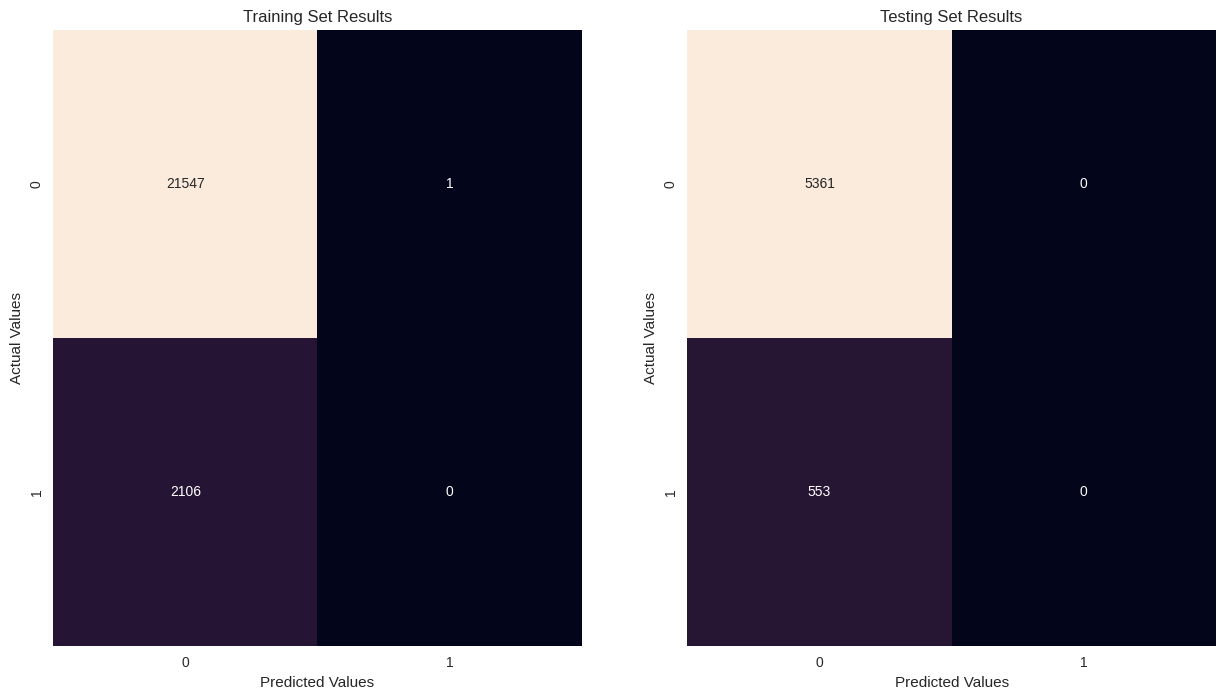

In [ ]:
# 2. Logistic Regression
lr_clf = LogisticRegressionCV()
lr_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'LogisticRegression' : lr_clf}
lr_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
lr_results

,Train_Recall,Test_Recall
LogisticRegression,0.0,0.0


**Logistic Regression seem to perform very poor**

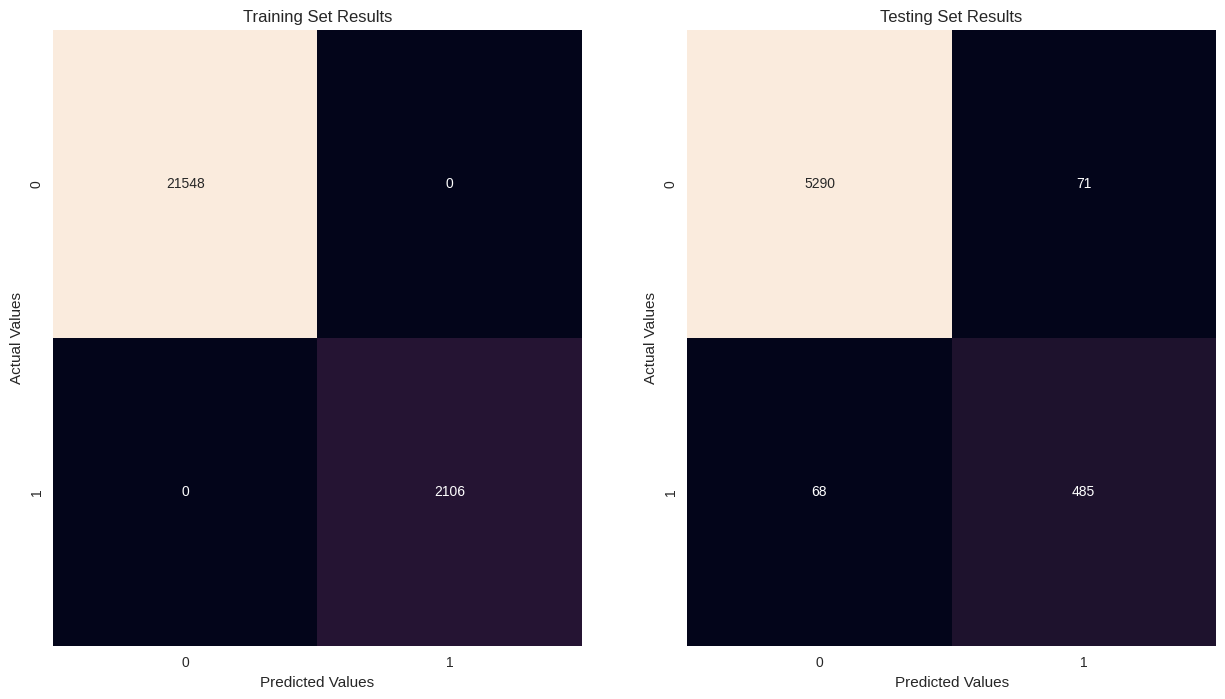

In [ ]:
# 3. Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'DecisionTree' : dt_clf}
dt_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
dt_results

,Train_Recall,Test_Recall
DecisionTree,1.0,0.877034


**Overfitting can be observed in case of Decision Trees**

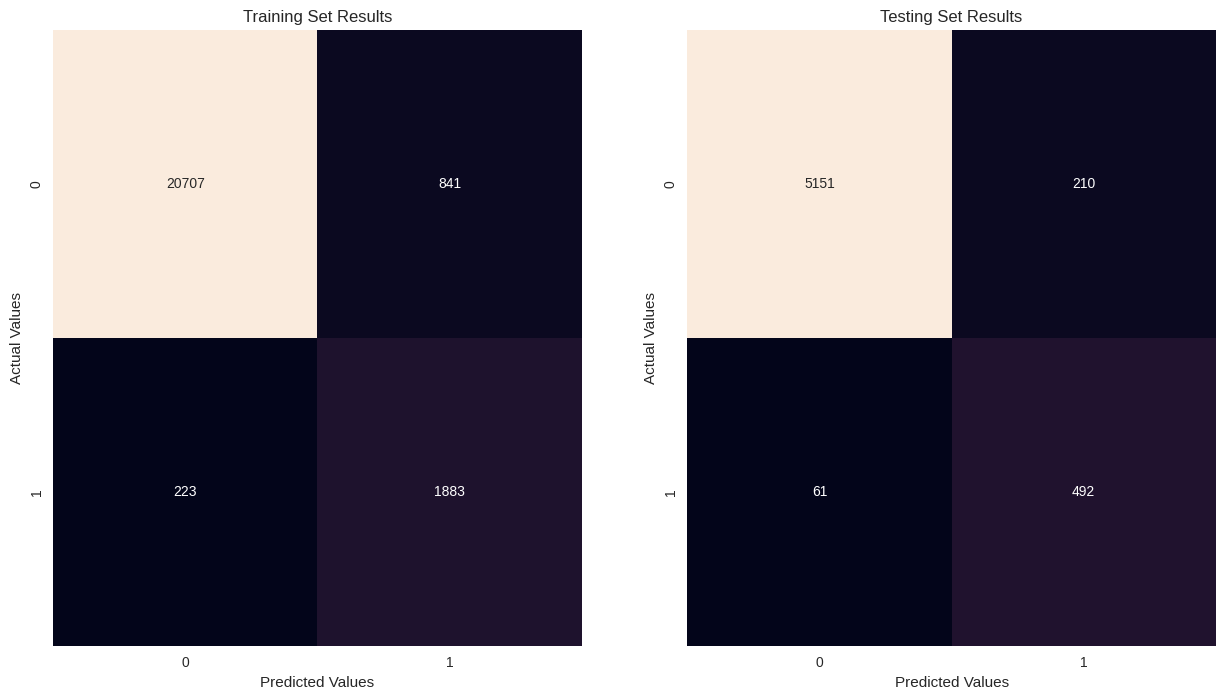

In [ ]:
# 4. SVM
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'SVM' : svm_clf}
svm_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
svm_results

,Train_Recall,Test_Recall
SVM,0.894112,0.889693


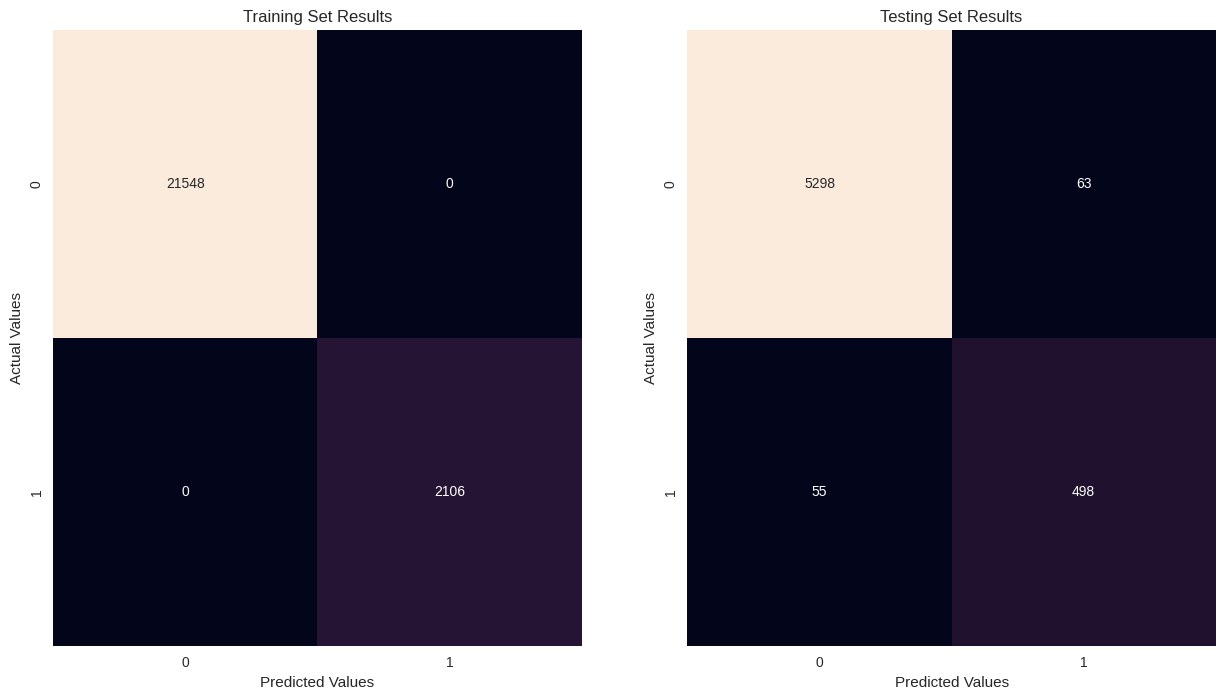

In [ ]:
# 5. Random Forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'RandomForest' : rf_clf}
rf_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
rf_results

,Train_Recall,Test_Recall
RandomForest,1.0,0.900542


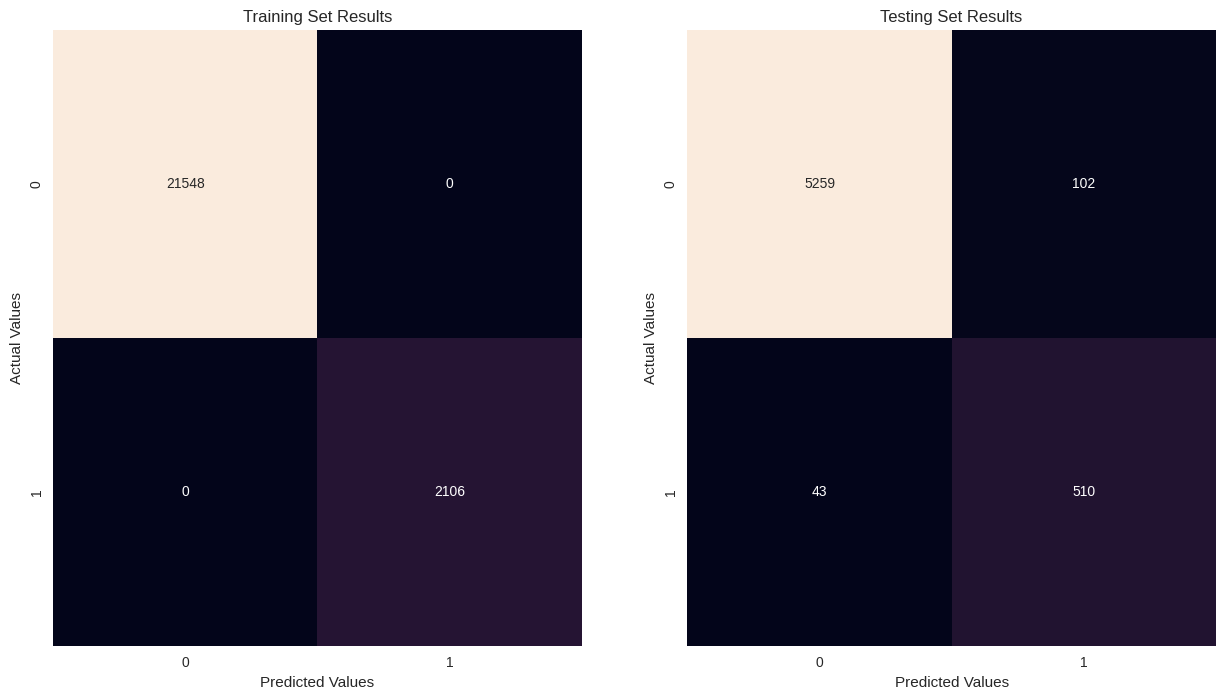

In [ ]:
# 6. Extra Trees
ext_clf = ExtraTreesClassifier()
ext_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'ExtraTrees' : ext_clf}
ext_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
ext_results

,Train_Recall,Test_Recall
ExtraTrees,1.0,0.922242


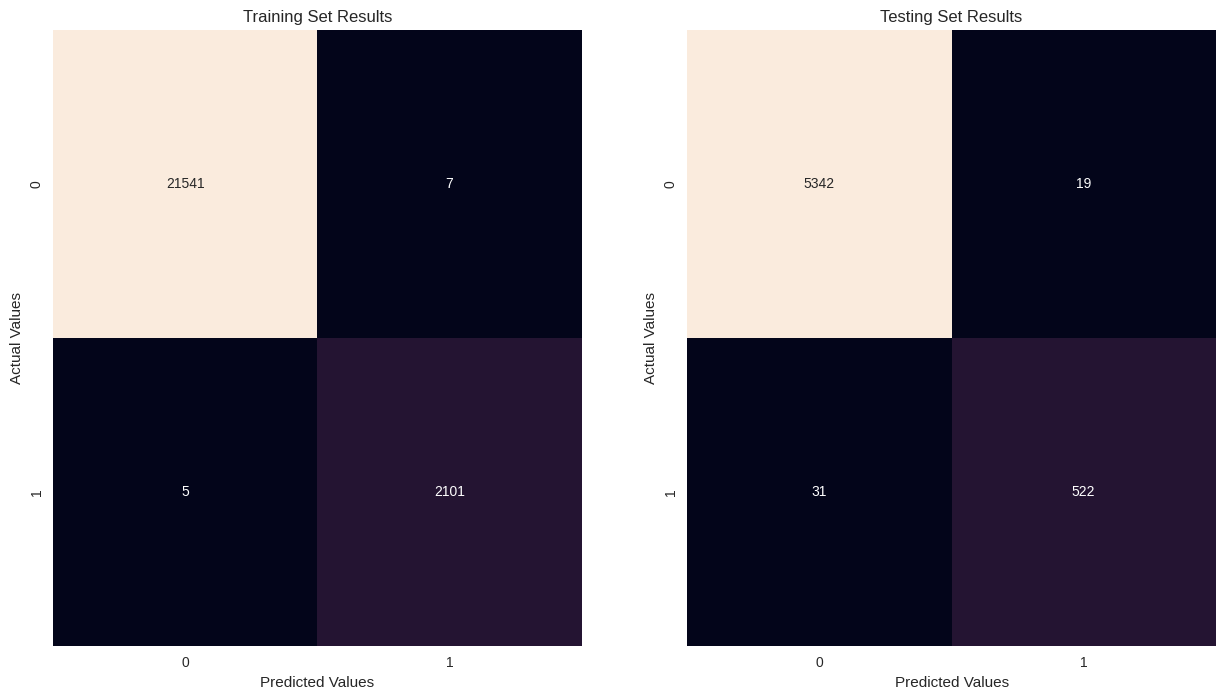

In [ ]:
# 7. XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'XGBoost' : xgb_clf}
xgb_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
xgb_results

,Train_Recall,Test_Recall
XGBoost,0.997626,0.943942


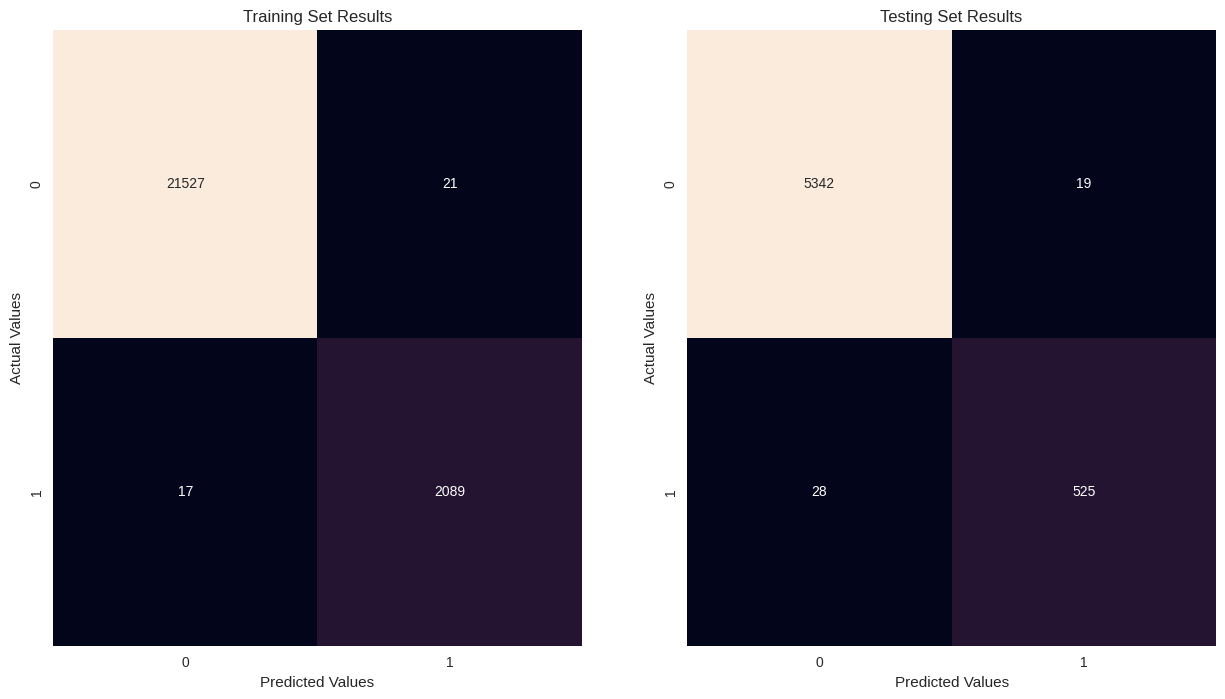

In [ ]:
# 8. LightGBM
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

# Compute Scores and plot confusion matrix
model_dict={'LightGBM' : lgbm_clf}
lgbm_results = compute_recall_score(model_dict=model_dict)
plot_confusion_matrix(model_dict=model_dict)

In [ ]:
lgbm_results

,Train_Recall,Test_Recall
LightGBM,0.991928,0.949367


In [ ]:
# Concatenate the results
final_results = pd.concat((knn_results, lr_results, 
                           svm_results, dt_results, 
                           rf_results, ext_results, 
                           xgb_results, lgbm_results), axis=0).sort_values(by='Test_Recall', ascending=False)
final_results

,Train_Recall,Test_Recall
LightGBM,0.991928,0.949367
XGBoost,0.997626,0.943942
ExtraTrees,1.000000,0.922242
RandomForest,1.000000,0.900542
SVM,0.894112,0.889693
DecisionTree,1.000000,0.877034
KNN,0.857075,0.759494
LogisticRegression,0.000000,0.000000



1.   XGBoost and SVM are giving generalised results.
2.   Extra Trees, Decision Tree and Random Forest seem to overfit a little.


## Hyperparameter Tuning

**Tune the top 2 models i.e LightGBM and ExtraTrees**

In [ ]:
# 1. Light GBM
lgbm_params = {"num_leaves" : [31, 50, 70, 90, 110],
               "max_depth" : [10, 20, 30, 40, 50, 60],
               "learning_rate" : [0.1, 0.5, 1, 1.5, 2.0],
               "n_estimators" : [100, 150, 200, 250, 300, 350],
               "reg_alpha" : [0.0, 0.25, 0.50, 0.75, 1.0, 2.0],
               "reg_lambda" : [0.0, 0.25, 0.50, 0.75, 1.0, 2.0],
               "colsample_bytree" : [0.0, 0.25, 0.50, 0.75, 1.0]
               }

lgbm_clf_2 = LGBMClassifier()

# using randomised search cv
rf_lgbm_clf = RandomizedSearchCV(lgbm_clf_2, lgbm_params, n_iter=20, scoring='recall', n_jobs=-1, cv=3, verbose=3, random_state=0)
rf_lgbm_clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.0, 0.25, 0.5,
                                                             0.75, 1.0],
                                        'learning_rate': [0.1, 0.5, 1, 1.5,
                                                          2.0],
                                        'max_depth': [10, 20, 30, 40, 50, 60],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350],
                                        'num_leaves': [31, 50, 70, 90, 110],
                                        'reg_alpha': [0.0, 0.25, 0.5, 0.75, 1.0,
                                                      2.0],
                                        'reg_lambda': [0.0, 0.25, 0.5, 0.75,
                                                       1.0, 2.0]},
                   random_state=0, scoring='recall', verbose=3)

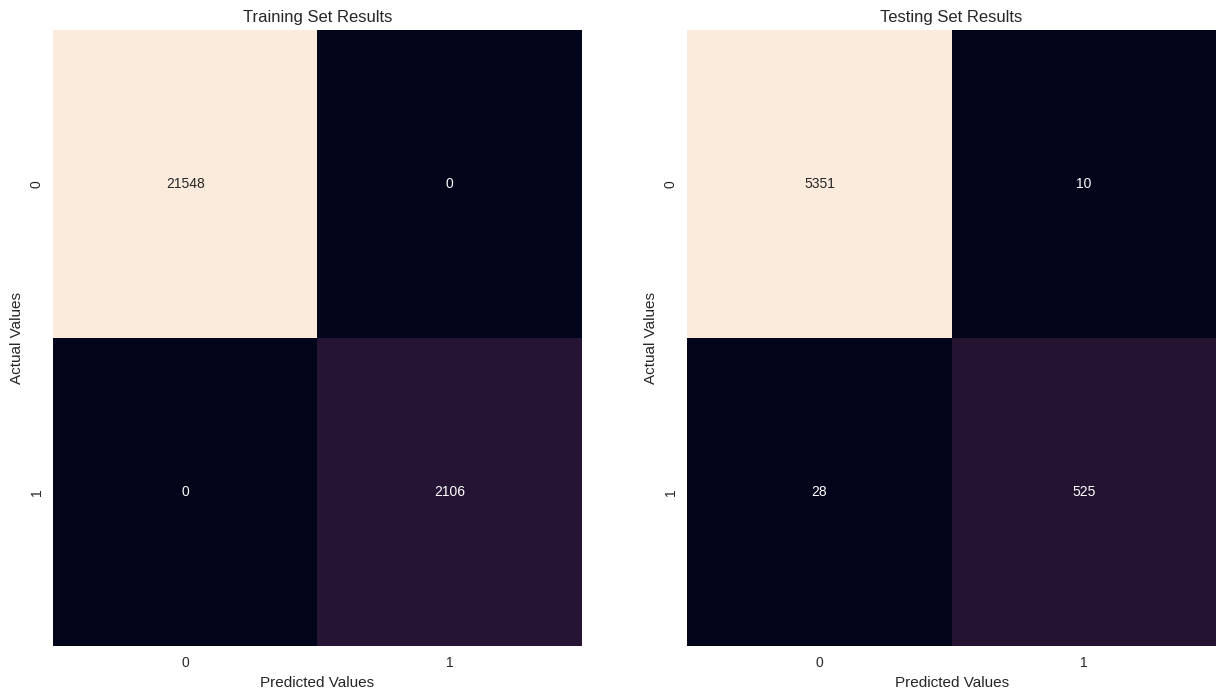

In [ ]:
# Store the Best estimator
lgbm_best = rf_lgbm_clf.best_estimator_

# Generate Results
model_dict = {'LGBM_Tuned' : lgbm_best}
lgbm_best_results = compute_recall_score(model_dict)
plot_confusion_matrix(model_dict)

In [ ]:
lgbm_best_results

,Train_Recall,Test_Recall
LGBM_Tuned,1.0,0.949367


In [ ]:
# 2. Extra Trees
ext_params = { "max_depth" : [10, 20, 30, 40, 50, 60],
               "criterion" : ['gini', 'entropy'],
               "n_estimators" : [100, 150, 200, 250, 300, 350],
               "max_features" : ["auto", "sqrt", "log2"],
               "min_samples_split" : [2, 4, 6, 8, 10],
               "min_samples_leaf" : [1, 2, 3, 4, 5, 6, 7],
               "bootstrap" : [True, False]
              }

ext_clf_2 = ExtraTreesClassifier()

# using randomised search cv
rf_ext_clf = RandomizedSearchCV(ext_clf_2, ext_params, n_iter=20, scoring='recall', n_jobs=-1, cv=3, verbose=3, random_state=0)
rf_ext_clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350]},
                   random_state=0, scoring='recall', verbose=3)

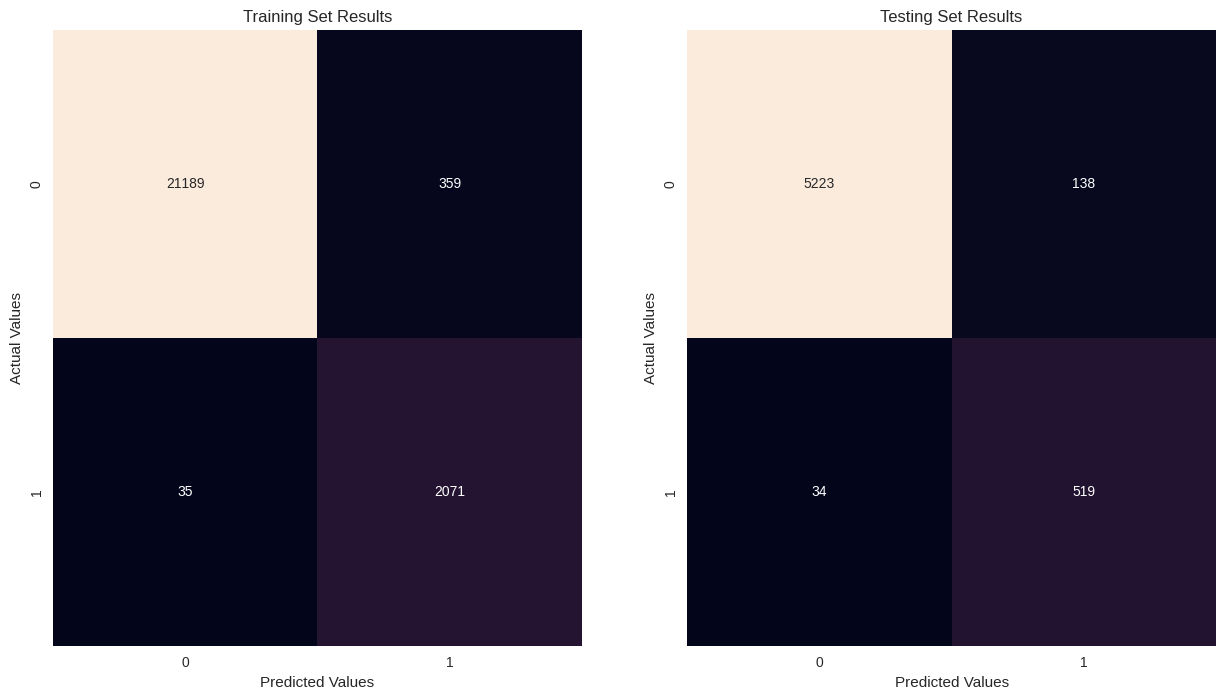

In [ ]:
# Store the Best estimator
ext_best = rf_ext_clf.best_estimator_

# Generate Results
model_dict = {'ExtraTrees_Tuned' : ext_best}
ext_best_results = compute_recall_score(model_dict)
plot_confusion_matrix(model_dict)

In [ ]:
ext_best_results

,Train_Recall,Test_Recall
ExtraTrees_Tuned,0.983381,0.938517


In [ ]:
# Train the best light GBM model on the entire dataset
lgbm_best.fit(X_scaled, y)

LGBMClassifier(colsample_bytree=0.5, max_depth=30, n_estimators=300,
               reg_alpha=0.75, reg_lambda=0.25)

In [ ]:
# Dump the Hyperparameter tunes LGBM model
model_file = '/content/drive/MyDrive/Colab Notebooks/Rain Predict/LightGBM.pkl'
pickle.dump(lgbm_best, open(model_file, 'wb'))